#In this lab exercise, your task is to employ Long Short-Term Memory (LSTM)
networks for time series prediction using the Airplane Passengers dataset available
for download. Begin by exploring and preprocessing the dataset, handling missing values,
and creating relevant features. Visualize trends and patterns using line plots, seasonal decomposition,
and other techniques. Design an LSTM model architecture suitable for time series forecasting, experimenting with layers,
hidden units, and activation functions. Tune hyperparameters such as learning rate and batch size for optimization.
Compile the model with appropriate loss functions and optimizers, then split the dataset into training, validation, and
testing sets. Train the LSTM model and monitor for overfitting using the validation set. Evaluate model performance using
Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE). Finally, optimize the model
based on evaluation results, implementing adjustments for enhanced forecasting accuracy. You can download the dataset using this link:


https://www.kaggle.com/datasets/rakannimer/air-passengers

#import libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#Data Processing

In [8]:
df=pd.read_csv("/content/AirPassengers.csv") # the path of datadet file

In [9]:
df.head(-5) #dataset visualisation

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
134,1960-03,419
135,1960-04,461
136,1960-05,472
137,1960-06,535


In [10]:
#2 column month and passens=gers
len(df.columns)

2

In [11]:
df.isnull()

,Month,#Passengers
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
139,False,False
140,False,False
141,False,False
142,False,False


In [12]:
No_of_passenger=df.columns[0]
time_of_travel=df.iloc[0]

In [13]:
No_of_passenger

'Month'

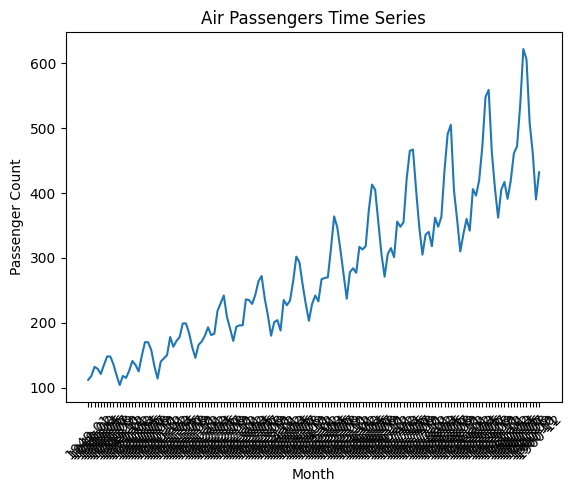

In [14]:
import matplotlib.pyplot as plt

# Assuming df contains the loaded DataFrame
plt.plot(df['Month'], df['#Passengers'])
plt.xlabel('Month')
plt.ylabel('Passenger Count')
plt.title('Air Passengers Time Series')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [15]:
from sklearn.preprocessing import StandardScaler #standarize the data because initial range is small and last data is large

scaler = StandardScaler()
df["#Passengers"] = scaler.fit_transform(df[["#Passengers"]])#standerizing the passengers column data

In [16]:
dtype=torch.float32# Preprocess data
scaler = MinMaxScaler(feature_range=(-1, 1)) #scales the data to a  range -1 to 1
df["#Passengers"] = scaler.fit_transform(df["#Passengers"].values.reshape(-1, 1))

In [17]:
# Define dataset class custom dataet
class AirPassengersDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length] # create_sequence of size seq_length
        y = self.data[idx + self.seq_length]  #store as label we predict y using x
        return (torch.tensor(x,dtype=torch.float32 ), torch.tensor(y,dtype=torch.float32 )) #tuple should be returned

In [29]:
# Split data into train and test sets
train_size = int(0.8 * len(df)) #80% train data
valid_size=int(0.2 * len(df)) #20% of train data in valid data
test_size = len(df) - train_size
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]
train_data,valid_data=train_data[:train_size-valid_size],train_data[:train_size]

In [30]:
# Initialize dataset and dataloaders
seq_length = 4
train_dataset = AirPassengersDataset(train_data["#Passengers"].values, seq_length)
valid_dataset=AirPassengersDataset(valid_data["#Passengers"].values, seq_length)
test_dataset = AirPassengersDataset(test_data["#Passengers"].values, seq_length)

#data loader to load the data
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
val_loader=DataLoader(valid_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [31]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size) #make fully connected to nodes using linear function

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)#previously initialised hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)#previously initialised cell state
        out, _ = self.lstm(x, (h0, c0)) # output of lstm class out,tuple of hidden state and cell state
        out = self.fc(out[:, -1, :])
        return out


In [32]:
# Initialize model, loss function, and optimizer
model = LSTMModel(input_size=1, hidden_size=100, num_layers=2, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [33]:
from sklearn.model_selection import ParameterGrid

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #configure device

In [40]:
# Define hyperparameters as dict key value pa
hyperparameters = {
    'hidden_size': [4, 8, 16],
    'num_layers': [1, 2],
    'learning_rate': [0.0001, 0.0003],
    'batch_size': [4,6]
}
# Training loop
best_model=None
train_losses=[]
val_losses=[]
best_val_loss = float('inf')
best_hyperparams = None
num_epochs=100
for params in ParameterGrid(hyperparameters): #for loop for all combination of hidden_size,num_layers,learning rate
    model = LSTMModel(input_size=1, hidden_size=params['hidden_size'], num_layers=params['num_layers'], output_size=1) #load model
    criterion = nn.MSELoss() #mse loss
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate']) #optimeser

    # Train model
    train_losses = []  #two list to store the train loss and val_losses
    val_losses = []
    for epoch in range(num_epochs):

        train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(-1))
            loss = criterion(outputs, labels.unsqueeze(-1)) #unsQueese  add extra dim
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for inputs, labels in val_loader:
                outputs = model(inputs.unsqueeze(-1))
                loss = criterion(outputs, labels.unsqueeze(-1))
                val_loss += loss.item() * inputs.size(0)
            val_loss /= len(val_loader.dataset)
            val_losses.append(val_loss)

        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # updating current model with best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_hyperparams = params #store best model parameters
        best_model_state = model.state_dict() #store best model weigths and other things
        best_model=model

print("Best hyperparameters:", best_hyperparams)


Epoch 1/100, Train Loss: 1.5531, Val Loss: 1.2557
Epoch 2/100, Train Loss: 1.5417, Val Loss: 1.2459
Epoch 3/100, Train Loss: 1.5304, Val Loss: 1.2363
Epoch 4/100, Train Loss: 1.5192, Val Loss: 1.2267
Epoch 5/100, Train Loss: 1.5081, Val Loss: 1.2172
Epoch 6/100, Train Loss: 1.4971, Val Loss: 1.2078
Epoch 7/100, Train Loss: 1.4862, Val Loss: 1.1986
Epoch 8/100, Train Loss: 1.4754, Val Loss: 1.1894
Epoch 9/100, Train Loss: 1.4647, Val Loss: 1.1803
Epoch 10/100, Train Loss: 1.4541, Val Loss: 1.1713
Epoch 11/100, Train Loss: 1.4437, Val Loss: 1.1624
Epoch 12/100, Train Loss: 1.4333, Val Loss: 1.1537
Epoch 13/100, Train Loss: 1.4231, Val Loss: 1.1450
Epoch 14/100, Train Loss: 1.4129, Val Loss: 1.1364
Epoch 15/100, Train Loss: 1.4029, Val Loss: 1.1279
Epoch 16/100, Train Loss: 1.3930, Val Loss: 1.1194
Epoch 17/100, Train Loss: 1.3831, Val Loss: 1.1111
Epoch 18/100, Train Loss: 1.3734, Val Loss: 1.1028
Epoch 19/100, Train Loss: 1.3637, Val Loss: 1.0947
Epoch 20/100, Train Loss: 1.3542, Val Lo

In [41]:
best_model_state

OrderedDict([('lstm.weight_ih_l0',
              tensor([[-0.1453],
                      [ 0.1246],
                      [ 0.1300],
                      [-0.2159],
                      [-0.0188],
                      [-0.1298],
                      [-0.2393],
                      [-0.1181],
                      [-0.3886],
                      [-0.1497],
                      [-0.0955],
                      [ 0.0568],
                      [ 0.0102],
                      [-0.2186],
                      [-0.2331],
                      [ 0.0700],
                      [ 0.0983],
                      [-0.0163],
                      [-0.1737],
                      [-0.1926],
                      [-0.1846],
                      [-0.1005],
                      [-0.1716],
                      [-0.1249],
                      [-0.2226],
                      [-0.3428],
                      [-0.0496],
                      [-0.2491],
                      [-0.0680],
        

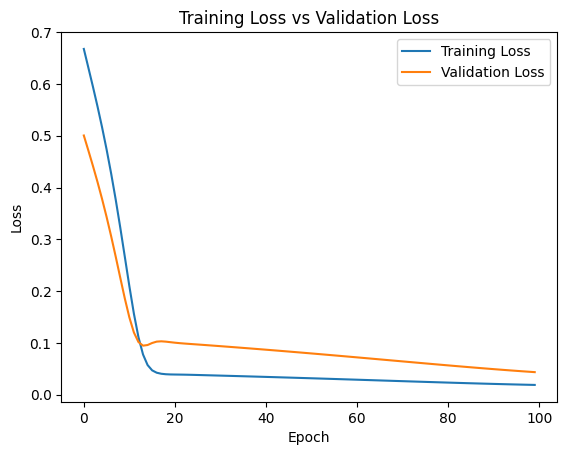

In [36]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()

# Show plot
plt.show()

In [44]:
# Evaluation

model.eval()
predictions = [] #store predictions
actual=[]
with torch.no_grad():
    for inputs, label in test_loader:
        actual.append(label.unsqueeze(-1))
        outputs = model(inputs.unsqueeze(-1))
        predictions.append(outputs.item())



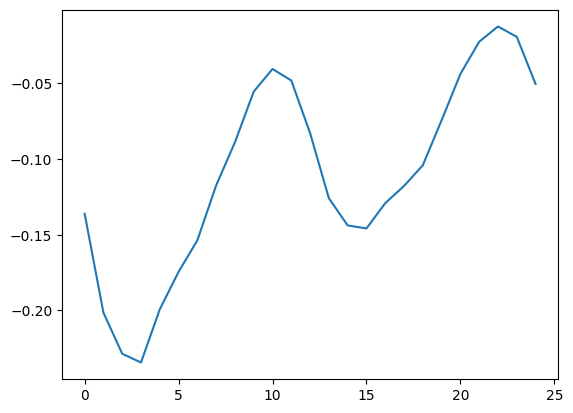

In [46]:
plt.plot(predictions, label='predictions')

In [43]:
# Inverse scaling
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))


In [39]:
# Calculate evaluation metrics
true_values = test_data["#Passengers"].values[seq_length:]
mse = np.mean((true_values - predictions.squeeze())**2)#return mse lose
rmse = np.sqrt(mse)
mape = np.mean(np.abs((true_values - predictions.squeeze()) / true_values)) * 100

print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

MSE: 0.09, RMSE: 0.30, MAPE: 781.09%
